In [1]:
#Image processing imports
import cv2
from skimage import measure

#Graphs & display imports
from matplotlib import pyplot as plt , animation
%matplotlib inline

#Array and variable maths import
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import signal as sig
from statistics import mean
import math

#GUI imports
from tkinter import filedialog
import tkinter as tk

#file IO imports
import os, sys

sys.path.append(r"C:\Users\Timothe\NasgoyaveOC\Professionnel\TheseUNIC\Scripts\Python\Librairies_Tim")

from LibrairieVSDAna import masks, ReadVSDfile
from LibUtils import network, image
from LibrairieVideoAna import ExtractFromDB 

import pyprind

from LibUtils import signal

In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray =  (1/3) * r + (1/3) * g + (1/3) * b 
    gray = gray.astype(np.uint8)
    return gray

def Distance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def Corner_detection(Centroid,Contour):
    mindist = 100000
    DistList = []
    for I in range(np.shape(Contour)[0]):
        dist = Distance(Centroid[0],Centroid[1],Contour[I,0],Contour[I,1])
        DistList.append(dist)
    Difflist = np.diff(DistList,n=1)
    return DistList,Difflist

def Trackers_binarize(image,threshold,claheobj):
    if len(np.shape(image)) > 2:
        image = rgb2gray(image)
    if clahe is not None:
        tempImg = claheobj.apply(image)
    else :
        tempImg = image
    _, binimg = cv2.threshold(tempImg,threshold,255,cv2.THRESH_BINARY)
    return binimg

def df_empty(columns, dtypes, index=None):
    assert len(columns)==len(dtypes)
    df = pd.DataFrame(index=index)
    for c,d in zip(columns, dtypes):
        df[c] = pd.Series(dtype=d)
    return df


In [60]:
class Trackers_find():
    
    def __init__(self,binImage,areamin,areamax):
        labels = measure.label(binImage, background=1)
        props = measure.regionprops(labels,coordinates='rc')
                
        coords = np.empty((0,2))
                
        self.items = df_empty(columns=['coords','orientation','area','indexs'], dtypes=[object,float,int,int])
        
        self.area = []
        self.index = []
        
        for index, label in enumerate(props):
            if label.area > areamin and label.area < areamax :
                if binImage[label.coords[0,0],label.coords[0,1]] != 0:
                    y0, x0 = label.centroid
                    
                    #row =  pd.DataFrame({"A": range(3)})
                    
                    #tracker.coords[found] = [x0, y0]
                    
                    #self.coords = np.append(self.coords,np.array([[x0, y0]]),axis = 0)
                    #tracker.orientation[found] = label.orientation
                    #self.area.append(label.area)
                    #self.index.append(index)
                    
                    self.items = self.items.append({'coords': [x0, y0], 'orientation': label.orientation, 'area': label.area, 'indexs': index}, ignore_index=True)

    
    def RemoveExtremaPos(self, INMindist, INMaxdist):
        
        if self.items.shape[0] > 2:
            #print("entred extrema pos--------------------")
            couplesList = []
            for I in range(self.items.shape[0]):
                for J in range(self.items.shape[0]):
                    if I == J :
                        continue
                    dist = Distance(self.items.coords[I][0], self.items.coords[I][1], self.items.coords[J][0], self.items.coords[J][1])
                    if dist >= INMindist and dist <= INMaxdist :
                        if J > I :
                            
                            tempAppend = [I,J]
                        else :
                            tempAppend = [J,I]
                        stop = 0
                        for T in range(len(couplesList)):
                            if couplesList[T] == tempAppend :
                                stop = 1
                        if stop :
                            break
                        else :
                            #print(f"Distance {dist} for couple {tempAppend}")
                            couplesList.append(tempAppend)

            if len(couplesList) > 0:
                #print(couplesList)
                temp = self.items.copy()
                temp = temp.drop(np.arange(0, self.items.shape[0],1).tolist())
                #display(self.items)
                treated = []
                loc = 0
                for I in range(len(couplesList)):
                    #print(f"couple {couplesList[I]}")
                    
                    if self.items.coords[couplesList[I][0]][1] < self.items.coords[couplesList[I][1]][1] :
                        if couplesList[I][0] not in treated :
                            #print(f"{couplesList[I][0]} = {self.items.coords[couplesList[I][0]][1]} is front")
                            temp.loc[loc] = self.items.loc[couplesList[I][0]]
                            loc = loc + 1
                            treated.append(couplesList[I][0])
                        else :
                            #print(f"{couplesList[I][1]} = {self.items.coords[couplesList[I][1]][1]} is already in dataframe")
                            pass
                        if couplesList[I][1] not in treated :
                            #print(f"{couplesList[I][1]} = {self.items.coords[couplesList[I][1]][1]} is back")
                            temp.loc[loc] = self.items.loc[couplesList[I][1]]
                            loc = loc + 1
                            treated.append(couplesList[I][1])
                        else :
                            #print(f"{couplesList[I][1]} = {self.items.coords[couplesList[I][1]][1]} is already in dataframe")
                            pass
                    else :
                        if couplesList[I][1] not in treated :
                            #print(f"{couplesList[I][1]} = {self.items.coords[couplesList[I][1]][1]} is front")
                            temp.loc[loc] = self.items.loc[couplesList[I][1]]
                            loc = loc + 1
                            treated.append(couplesList[I][1])
                        else :
                            #print(f"{couplesList[I][1]} = {self.items.coords[couplesList[I][1]][1]} is already in dataframe")
                            pass
                        if couplesList[I][0] not in treated :
                            #print(f"{couplesList[I][0]} = {self.items.coords[couplesList[I][0]][1]} is back")
                            temp.loc[loc] = self.items.loc[couplesList[I][0]]
                            loc = loc + 1
                            treated.append(couplesList[I][0])
                        else :
                            #print(f"{couplesList[I][1]} = {self.items.coords[couplesList[I][1]][1]} is already in dataframe")
                            pass
                self.items = temp
    
    def GetContour(self,binImage):
        
        TempContours = measure.find_contours(binImage, 0.8)
        #print(f"found {np.shape(self.coords)[0]} trackers")
        self.contours = np.full((np.shape(self.coords)[0],2),np.nan,dtype=object)              
        
        for I in range(np.shape(self.coords)[0]):
            mindist = 100000
            saveIndex = None
            for n, contour in enumerate(TempContours):
                x_centroid = np.mean(contour[:, 1])
                y_centroid = np.mean(contour[:, 0])
                dist = Distance(x_centroid,y_centroid,self.coords[I,0],self.coords[I,1])
                if mindist > dist :
                    mindist = dist
                    saveIndex = n

            #ARR_cont = measure.subdivide_polygon(contour, degree=2, preserve_ends=True)
            ARR_cont = measure.approximate_polygon(TempContours[saveIndex], tolerance=0.5)

            self.contours[I,:] = [ARR_cont[:,1].tolist(),ARR_cont[:,0].tolist()]

class Trackers_clean():
    
    def __init__(self):
        self.FrameDict = {}
        self.IndexDict = {}
        self.frame = 0
        self.Init = False 
        
    def AddFrame(self,TrackerObjDataframe):
        if TrackerObjDataframe.shape[0] >= 2:
            self.FrameDict.update([(f"{self.frame}" , TrackerObjDataframe)])
            self.IndexDict.update([(f"{self.frame}" , int(self.frame))])
            
        else :
            temp = TrackerObjDataframe.copy()
            temp = temp.drop(np.arange(0, TrackerObjDataframe.shape[0],1).tolist())
            self.FrameDict.update([(f"{self.frame}" , temp)])
            self.IndexDict.update([(f"{self.frame}" , int(self.frame))])
            
        self.frame = self.frame +1
    def MakeSequence(self):
        self.Sequence = pd.concat(self.FrameDict.values(), axis=0, keys=self.IndexDict.values(),names = ['Frame','Trkid'])     
        
    def CleanSequence(self,min_consecutive,maxdist,secondpass=False):
             
        prepos = []
        catch = 0
        serie = []
        
        self.Sequence.sort_index(level = 0, axis = 0 , inplace = True, ascending = True)
        
        for frame, items in self.Sequence.groupby(level=0):

            if items.shape[0] == 1:
                self.Sequence.drop(labels = frame, axis = 0, level = 0, inplace=True)
                catch = 0
                uncatch = uncatch + 1
                prepos = []

            elif items.shape[0] == 2:

                pos = [   mean( [ self.Sequence.loc[frame,0]["coords"][0],self.Sequence.loc[frame,1]["coords"][0] ] ) , mean( [ self.Sequence.loc[frame,0]["coords"][1],self.Sequence.loc[frame,1]["coords"][1] ] ) ]
 
                if len(prepos) : 

                    if Distance(prepos[0], prepos[1], pos[0], pos[1]) < maxdist :
                        catch = catch + 1
                        serie.append(frame)

                    else :
                        if catch > 0 and catch < min_consecutive :
                            for delete in serie:
                                self.Sequence.drop(labels = delete, axis = 0, level = 0, inplace=True)
                            catch = 1
                            serie = [frame]
                        else :
                            catch = 1
                            serie = [frame]
                else :
                    catch = catch + 1
                    serie.append(frame)

                prepos = pos
  
            elif items.shape[0] > 2:

                if catch > min_consecutive :

                    dists = []
                    locs = []
                    for index in range(items.shape[0]): 
                        for index2 in range(items.shape[0]): 
                            if index >= index2 : 
                                continue
                            pos = [   mean( [ self.Sequence.loc[frame,index]["coords"][0],self.Sequence.loc[frame,index2]["coords"][0] ] ) , mean( [ self.Sequence.loc[frame,index]["coords"][1],self.Sequence.loc[frame,index2]["coords"][1] ] ) ]
                            dists.append(Distance(prepos[0], prepos[1], pos[0], pos[1]))
                            locs.append([index,index2])

                    select = np.argmin(np.asarray(dists))

                    for index in range(items.shape[0]): 
                        if index not in locs[select]:
                            self.Sequence.drop((frame,index), inplace=True)

                    newmultindex = self.Sequence.loc[frame]

                    i = 0
                    for index, row in newmultindex.iterrows():

                        self.Sequence.drop((frame,index), inplace=True)

                        self.Sequence.loc[(frame,i), ['coords','orientation','area','indexs']] = row.tolist()
                        i = i + 1
                        
                    pos = [   mean( [ self.Sequence.loc[frame,0]["coords"][0], self.Sequence.loc[frame,1]["coords"][0] ] ) , mean( [ self.Sequence.loc[frame,0]["coords"][1], self.Sequence.loc[frame,1]["coords"][1] ] ) ]
                    if len(prepos) : 

                        if Distance(prepos[0], prepos[1], pos[0], pos[1]) < maxdist :
                            catch = catch + 1
                            serie.append(frame)

                        else :
                            if catch > 0 and catch < min_consecutive :
                                for delete in serie:
                                    self.Sequence.drop(labels = delete, axis = 0, level = 0, inplace=True)
                                catch = 1
                                serie = [frame]
                            else :
                                catch = 1
                                serie = [frame]
                    else :
                        catch = catch + 1
                        serie.append(frame)

                    prepos = pos

        self.Sequence.sort_index(level = 0, axis = 0 , inplace = True, ascending = True)

        
        if secondpass :
            
            prepos = []
            catch = 0
            serie = []

                        
            FramesValues = np.flip( np.unique( self.Sequence.index.get_level_values(0).tolist() ) , axis = 0 ).tolist()
            print(FramesValues)
            for frame in FramesValues:
                items = self.Sequence.loc[frame,:]

                if items.shape[0] == 1:
                    self.Sequence.drop(labels = frame, axis = 0, level = 0, inplace=True)
                    catch = 0
                    uncatch = uncatch + 1
                    prepos = []

                elif items.shape[0] == 2:

                    pos = [   mean( [ self.Sequence.loc[frame,0]["coords"][0],self.Sequence.loc[frame,1]["coords"][0] ] ) , mean( [ self.Sequence.loc[frame,0]["coords"][1],self.Sequence.loc[frame,1]["coords"][1] ] ) ]

                    if len(prepos) : 

                        if Distance(prepos[0], prepos[1], pos[0], pos[1]) < maxdist :
                            catch = catch + 1
                            serie.append(frame)
    
                        else :
                            if catch > 0 and catch < min_consecutive :
                                for delete in serie:
                                    self.Sequence.drop(labels = delete, axis = 0, level = 0, inplace=True)
                                catch = 1
                                serie = [frame]
                            else :
                                catch = 1
                                serie = [frame]
                    else :
                        catch = catch + 1
                        serie.append(frame)
        
                    prepos = pos
 

                elif items.shape[0] > 2:

                    if catch > min_consecutive :

                        dists = []
                        locs = []
                        for index in range(items.shape[0]): 
                            for index2 in range(items.shape[0]): 
                                if index >= index2 : 
                                    continue
                                pos = [   mean( [ self.Sequence.loc[frame,index]["coords"][0],self.Sequence.loc[frame,index2]["coords"][0] ] ) , mean( [ self.Sequence.loc[frame,index]["coords"][1],self.Sequence.loc[frame,index2]["coords"][1] ] ) ]
                                dists.append(Distance(prepos[0], prepos[1], pos[0], pos[1]))
                                locs.append([index,index2])

                        select = np.argmin(np.asarray(dists))

                        for index in range(items.shape[0]): 
                            if index not in locs[select]:
                                self.Sequence.drop((frame,index), inplace=True)

                        newmultindex = self.Sequence.loc[frame]

                        i = 0
                        for index, row in newmultindex.iterrows():

                            self.Sequence.drop((frame,index), inplace=True)

                            self.Sequence.loc[(frame,i), ['coords','orientation','area','indexs']] = row.tolist()
                            i = i + 1

                        pos = [   mean( [ self.Sequence.loc[frame,0]["coords"][0], self.Sequence.loc[frame,1]["coords"][0] ] ) , mean( [ self.Sequence.loc[frame,0]["coords"][1], self.Sequence.loc[frame,1]["coords"][1] ] ) ]
                        
                        if len(prepos) : 

                            if Distance(prepos[0], prepos[1], pos[0], pos[1]) < maxdist :
                                catch = catch + 1
                                serie.append(frame)

                            else :
                                if catch > 0 and catch < min_consecutive :
                                    for delete in serie:
                                        self.Sequence.drop(labels = delete, axis = 0, level = 0, inplace=True)
                                    catch = 1
                                    serie = [frame]
                                else :
                                    catch = 1
                                    serie = [frame]
                        else :
                            catch = catch + 1
                            serie.append(frame)

                        prepos = pos

        self.Sequence.sort_index(level = 0, axis = 0 , inplace = True, ascending = True)
   


    def MakeMerge(self):
        self.FrameDict = {}
        lastpos = []
        lastframe = None
        capture = 0
        lastspeed = None
        
        Iter = np.flip( np.unique( self.Sequence.index.get_level_values(0).tolist() ) , axis = 0 ).tolist()
        
        for frame, items in self.Sequence.groupby(level=0):
            
            Xmean = mean( [ self.Sequence.loc[frame,0]["coords"][0], self.Sequence.loc[frame,1]["coords"][0] ] )
            Ymean = mean( [ self.Sequence.loc[frame,0]["coords"][1], self.Sequence.loc[frame,1]["coords"][1] ] )
            
            if capture == 0 :
                speed = np.nan
                accel = np.nan
            elif capture == 1 :
                speed = Distance( lastpos[0], lastpos[1], Xmean, Ymean )
                accel = np.nan
                lastspeed = speed
            elif capture >= 2:
                speed = Distance( lastpos[0], lastpos[1], Xmean, Ymean )
                accel = speed - lastspeed
                lastspeed = speed
                
                
            if lastframe is not None :  
                if frame == lastframe + 1:
                    capture = capture + 1
                else :
                    capture = 1
                    
            lastframe = frame
            lastpos = [Xmean,Ymean]
            
            a = np.array([self.Sequence.loc[frame,0]["coords"][0],  self.Sequence.loc[frame,0]["coords"][1]])
            b = np.array([self.Sequence.loc[frame,1]["coords"][0],  self.Sequence.loc[frame,1]["coords"][1]])
            c = np.array([self.Sequence.loc[frame,0]["coords"][0]+10,  self.Sequence.loc[frame,0]["coords"][1]])

            ba = a - b
            bc = c - b

            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
            angle = np.degrees(np.arccos(cosine_angle))
            
            tempdict = {'coords': [[Xmean,Ymean]] , 'angle':angle, 'speed':speed, 'accel':accel}
            #tempframe = pd.DataFrame( np.asarray( [[Xmean,Ymean] ,angle ,speed ,accel] ) , columns = ['coords', 'angle', 'speed', 'accel'], dtypes = [list,float,float,float] ) 
            #tempframe = pd.concat(tempdict.values(), axis=1, keys=tempdict.keys())
            tempframe = pd.DataFrame(tempdict ) #dtype = ['O','f','f','f']
            self.FrameDict.update( [ ( int(frame), tempframe ) ] )
            
        self.Merge = pd.concat(self.FrameDict.values(), axis=0, keys=self.FrameDict.keys(), names = ['Frames']).droplevel(1,axis=0)   

# Loading a frame

In [61]:
rootfolder = network.find_favoritesRootFolder()
SessionDataFrame = ExtractFromDB.SessionDataframe( 1656 , rootfolder)

D:


,session_id,session_date,mouse_number,batch_name
0,1655,2020-03-03 11:25:33,25,Expect_1
1,1656,2020-03-03 11:48:54,25,Expect_1
2,1657,2020-03-03 12:09:22,25,Expect_1


,session_id,session_date,mouse_number,batch_name
0,1655,2020-03-03 11:25:33,25,Expect_1
1,1656,2020-03-03 11:48:54,25,Expect_1
2,1657,2020-03-03 12:09:22,25,Expect_1


 ## Option with skimage measure and skimage regionprops 

Tracking a video


100
D:BehavioralVideos\Whisker_Video\Whisker_Topview\Expect_1\Mouse25\200303_VSD2\Mouse25_2020-03-03T11.48.35.avi


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:48


Cleaning
[499, 498, 497, 496, 495, 494, 493, 492, 491, 490, 489, 488, 487, 486, 485, 484, 483, 482, 481, 480, 479, 478, 477, 476, 475, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464, 463, 462, 461, 460, 459, 458, 457, 456, 455, 454, 453, 452, 451, 450, 449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 439, 438, 437, 436, 435, 434, 433, 432, 431, 430, 429, 428, 427, 426, 425, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412, 411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386, 385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 

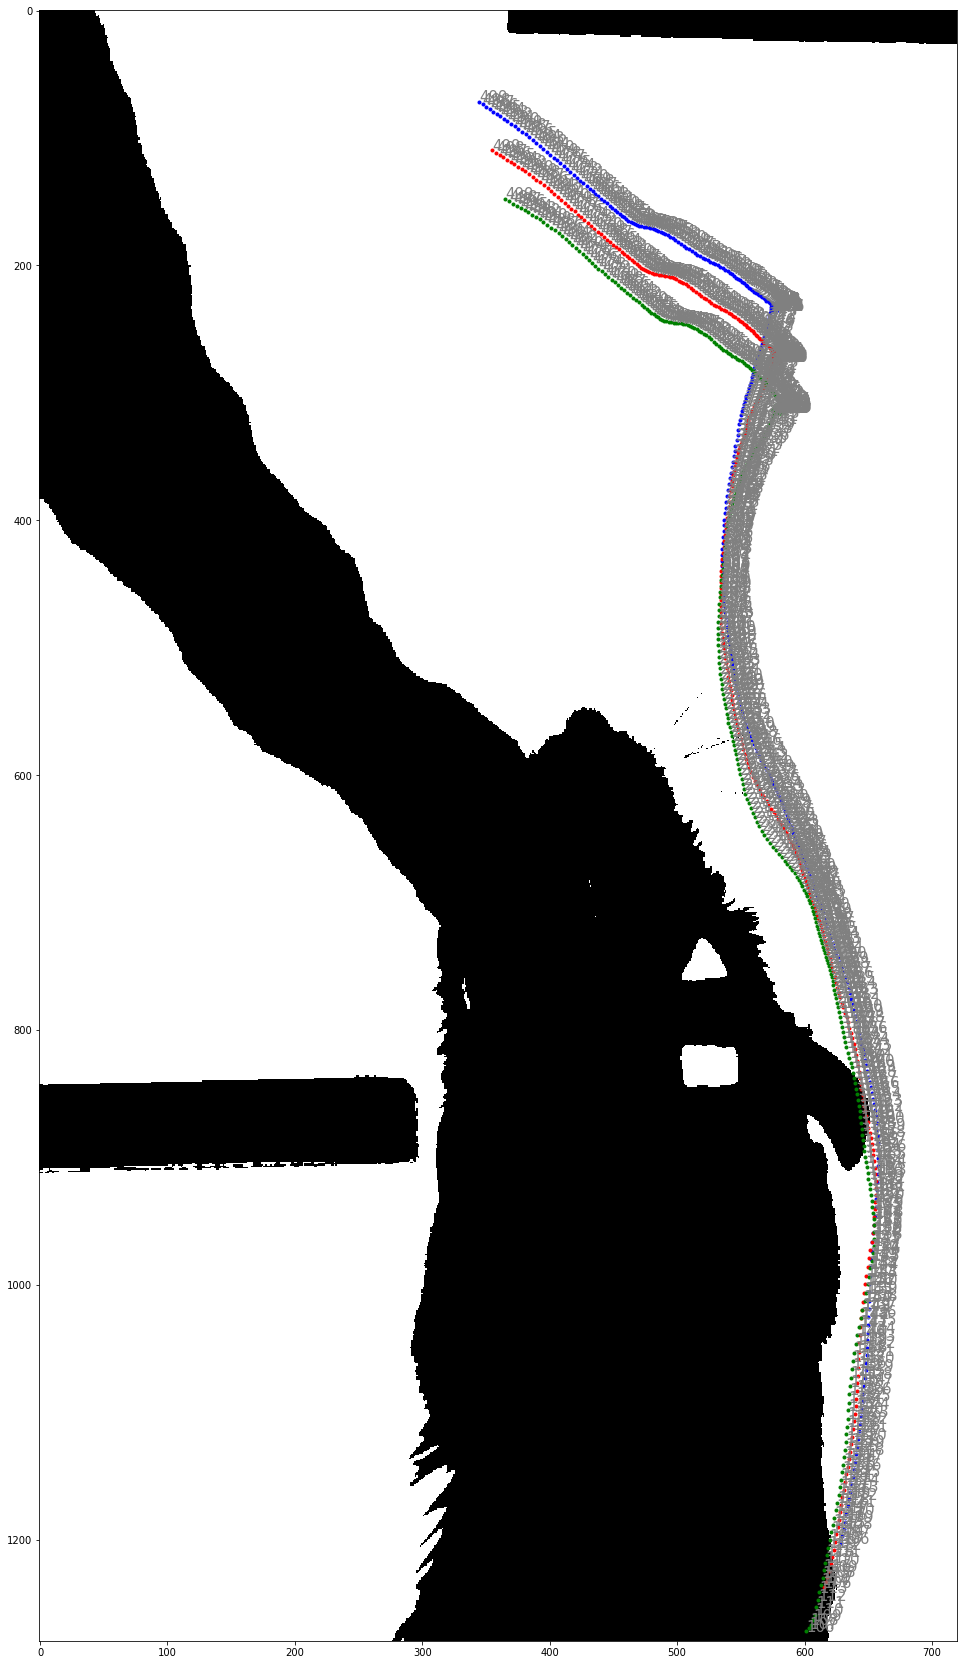

In [62]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))

HandleTOP = cv2.VideoCapture(SessionDataFrame.at[5,"BEHpath"] ,cv2.IMREAD_GRAYSCALE)
NumberOfFrames = int(HandleTOP.get(cv2.CAP_PROP_FRAME_COUNT))
HandleTOP.set(cv2.CAP_PROP_POS_FRAMES, 170)
_ , IMG1 = HandleTOP.read()
IMG1 = np.rot90(IMG1,1)
IMG1 = IMG1.astype(np.uint8)

BinIMG1 = Trackers_binarize(IMG1,50,clahe)

fig = plt.figure(figsize = (40,30))
plt.imshow(BinIMG1, cmap='gray', vmin=0, vmax=1)

#SessionDataFrame.at[trial,"BEHpath"]

print(SessionDataFrame["BEHpath"].shape[0])

for index, I in enumerate(SessionDataFrame["BEHpath"]):
    if index == 0:
        continue
    if int(index) >= 3:
        break
    
    HandleTOP = cv2.VideoCapture(SessionDataFrame.at[int(index),"BEHpath"] ,cv2.IMREAD_GRAYSCALE)
    print(SessionDataFrame.at[int(index),"BEHpath"])
    HandleTOP.set(cv2.CAP_PROP_POS_FRAMES, 0)

    colors = ['red','blue','yellow','yellow','yellow','yellow']

    bar = pyprind.ProgBar(NumberOfFrames, track_time=True, title='Tracking a video',bar_char='█')

    videoTrack = Trackers_clean()

    for frameid in range(NumberOfFrames):
        bar.update()
        
        _ , TempIMG = HandleTOP.read()
        TempIMG = np.rot90(TempIMG,1)
        
        BinIMG = Trackers_binarize(TempIMG,50,clahe)
        Trk = Trackers_find(BinIMG,500,2000)
        Trk.RemoveExtremaPos(40 , 130)
        
        videoTrack.AddFrame(Trk.items)
        

    del Trk
    videoTrack.MakeSequence()
    print("Cleaning")
    videoTrack.CleanSequence(7,10,True)
    
    #plt.plot(Trk.contours[I,0],Trk.contours[I,1],'-',linewidth = 3, color = colors[I])
    for frame, item in videoTrack.Sequence.groupby(level=0):

        Xmean = mean( [ videoTrack.Sequence.loc[frame,0]["coords"][0], videoTrack.Sequence.loc[frame,1]["coords"][0] ] )
        Ymean = mean( [ videoTrack.Sequence.loc[frame,0]["coords"][1], videoTrack.Sequence.loc[frame,1]["coords"][1] ] )
        plt.plot(Xmean,Ymean,'o',markersize = 3, color = "red")
        plt.plot(videoTrack.Sequence.loc[frame,0]["coords"][0]  ,videoTrack.Sequence.loc[frame,0]["coords"][1],'o',markersize = 3, color = "blue")
        plt.plot(videoTrack.Sequence.loc[frame,1]["coords"][0]  ,videoTrack.Sequence.loc[frame,1]["coords"][1],'o',markersize = 3, color = "green")
        
        plt.text(videoTrack.Sequence.loc[frame,0]["coords"][0]  ,videoTrack.Sequence.loc[frame,0]["coords"][1], frame, fontsize=15, color = 'gray')
        plt.text(videoTrack.Sequence.loc[frame,1]["coords"][0]  ,videoTrack.Sequence.loc[frame,1]["coords"][1], frame, fontsize=15, color = 'gray')
        
        plt.text(Xmean, Ymean, frame, fontsize=15, color = 'gray')
        
    
    
    videoTrack.MakeMerge()
    break
    
plt.show()
#plt.savefig("TrackerTrajectory.png")

In [64]:

pd.set_option('display.max_rows', 1000)
display(videoTrack.Merge.droplevel(1,axis=0))
#display(videoTrack.Sequence)


,coords,angle,speed,accel
Frames,,,,
106,"[614.962814659, 1237.56352886]",6.834786,NaN,NaN
107,"[616.531891026, 1233.45894149]",6.681081,NaN,NaN
108,"[617.815103961, 1229.14900449]",6.498964,4.496909,NaN
109,"[619.262971459, 1224.73464439]",6.417404,4.645739,0.148830
110,"[620.660221914, 1219.59333564]",6.360532,5.327792,0.682052
111,"[621.525673099, 1213.6415924]",6.342387,6.014337,0.686546
112,"[622.785793292, 1207.98987859]",6.367309,5.790490,-0.223848
113,"[623.700305132, 1202.01383148]",6.374325,6.045616,0.255126
114,"[624.844873581, 1196.05766186]",6.394590,6.065146,0.019530


In [ ]:
lastTrackers = []
#test = videoTrack.Sequence.groupby(level=0)
#display(videoTrack.Sequence)
prepos = []
catch = 0
for frame, items in videoTrack.Sequence.groupby(level=0):
    temp = []
    #print(items,frame)
    
    if items.shape[0] == 1:
        videoTrack.Sequence.drop(labels = frame, axis = 0, level = 0, inplace=True)
        print(f"dropped {items} , {frame}" )
    
    elif items.shape[0] == 2:
        #print(videoTrack.Sequence.loc[frame,0]["coords"][0] ,  videoTrack.Sequence.loc[frame,0]["coords"][1])
        pos = [   mean( [ videoTrack.Sequence.loc[frame,0]["coords"][0],videoTrack.Sequence.loc[frame,1]["coords"][0] ] ) , mean( [ videoTrack.Sequence.loc[frame,0]["coords"][1],videoTrack.Sequence.loc[frame,1]["coords"][1] ] ) ]
        #print(pos)
        if len(prepos) : 
            if Distance(prepos[0], prepos[1], pos[0], pos[1]) < 15 :
                catch = catch + 1
            else :
                catch = 0
        print(catch)
        prepos = pos
        
    elif items.shape[0] > 2:
        
        if catch > 7 :
            print("filtering")
            dists = []
            locs = []
            for index in range(items.shape[0]): 
                for index2 in range(items.shape[0]): 
                    if index >= index2 : 
                        continue
                    pos = [   mean( [ videoTrack.Sequence.loc[frame,index]["coords"][0],videoTrack.Sequence.loc[frame,index2]["coords"][0] ] ) , mean( [ videoTrack.Sequence.loc[frame,index]["coords"][1],videoTrack.Sequence.loc[frame,index2]["coords"][1] ] ) ]
                    dists.append(Distance(prepos[0], prepos[1], pos[0], pos[1]))
                    locs.append([index,index2])
            print(dists)
            print(locs)
            select = np.argmin(np.asarray(dists))
            
            for index in range(items.shape[0]): 
                if index not in locs[select]:
                    print(index)
                    videoTrack.Sequence.drop((frame,index), inplace=True)
            
            newmultindex = videoTrack.Sequence.loc[frame]
            print(newmultindex)
            i = 0
            for index, row in newmultindex.iterrows():
                print(f"Item left : {index}")
                videoTrack.Sequence.drop((frame,index), inplace=True)
                print(row.tolist())
                videoTrack.Sequence.loc[(frame,i), ['coords','orientation','area','indexs']] = row.tolist()
                i = i + 1

                #print(videoTrack.Sequence.loc[frame,index][])
            pos = [   mean( [ videoTrack.Sequence.loc[frame,0]["coords"][0],videoTrack.Sequence.loc[frame,1]["coords"][0] ] ) , mean( [ videoTrack.Sequence.loc[frame,0]["coords"][1],videoTrack.Sequence.loc[frame,1]["coords"][1] ] ) ]
            if Distance(prepos[0], prepos[1], pos[0], pos[1]) < 15 :
                catch = catch + 1
            else :
                catch = 0
            prepos = pos
            
        else :
            print("cannot filter")
        
        
        
    #for index, row in items.iterrows(): 
        #self.Sequence.at[(frame,index),'coords']
        #print(index,videoTrack.Sequence.loc[index]['coords'])
        #temp.append(videoTrack.Sequence.loc[index]['coords'])
    #print(temp)
    #if frame > 110:
    #    break
    
pd.set_option('display.max_rows', 1000)
display(videoTrack.Sequence)

In [ ]:
pd.set_option('display.max_rows', 500)
display(videoTrack.Sequence)